## 5.6 专题：线性回归
> * 5.6.1 简单线性回归
* 5.6.2 基函数回归
* 5.6.3 正则化

<br>
### 5.6.1 简单线性回归
> 将数据拟合成一条直线，拟合方程为：
<center>y = ax+b</center>

> 其中a是直线斜率，b是截距

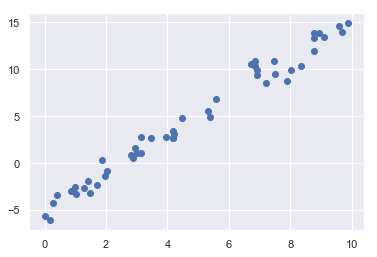

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

rng = np.random.RandomState(1)
x = 10*rng.rand(50)
y = 2*x -5+rng.randn(50)
plt.scatter(x,y)

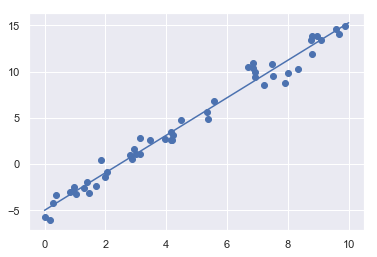

In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(x[:,np.newaxis],y)
X_test = np.linspace(0,10,1000)
y_pred = model.predict(X_test[:,np.newaxis])
plt.scatter(x,y)
plt.plot(X_test,y_pred)

In [12]:
print('斜率：',model.coef_)
print('截距：',model.intercept_)

斜率： [2.02720881]
截距： -4.998577085553202


>还可以拟合多维度回归模型：
<center>$y = a_0+a_1x_1+a_2x_2+...$</center>

In [13]:
X = 10*rng.rand(100,3)
y = 0.5+np.dot(X,[1.5,-2,1])

model.fit(X,y)
print(model.coef_)
print(model.intercept_)

[ 1.5 -2.   1. ]
0.4999999999999982


---
### 5.6.2 基函数回归
> 通过基函数对原始数据进行变换，从而将变量间的线性回归模型转换成非线性回归模型。
<center>$y=a_0+a_1x_1+a_2x_2+a_3x_3+...$</center>

> 其中一维的输入变量x转换成了三维变量$x_1、x_2、x_3$, 让$x_n=f_n(x)$。($f_n$是转换数据的函数)<br>
假如$f_n(x)=x^n$，则模型就变成多项式回归：
<center>$y=a_0+a_1x+a_2x^2+a_3x^3+...$</center>
<br>

#### 1.多项式基函数

In [15]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2,3,4])
poly = PolynomialFeatures(3,include_bias=False)
poly.fit_transform(x[:,None])
#转换器通过指数函数，将一维数组转换成了三维数组，这个高维数组可以放在多项式回归模型中

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

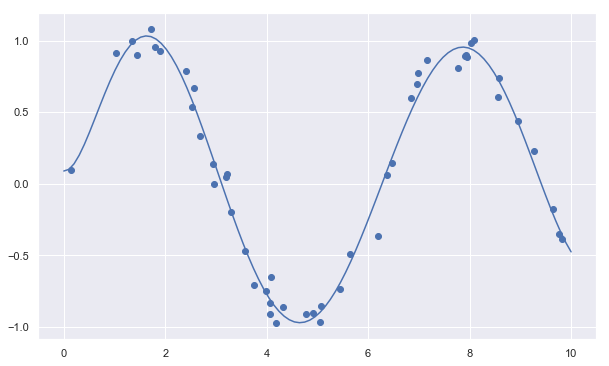

In [19]:
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(7),LinearRegression())

x = 10*rng.rand(50)
y = np.sin(x)+0.1*rng.randn(50)
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(x,y)
X = np.linspace(0,10,100)[:,np.newaxis]
y_model = poly_model.fit(x[:,np.newaxis],y).predict(X)
ax.plot(X,y_model)

In [26]:
poly_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=7, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])>

### 2.高斯基函数


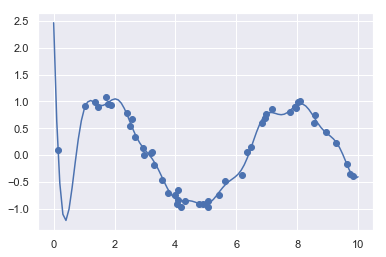

In [36]:
from sklearn.base import BaseEstimator,TransformerMixin
class GaussianFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,N,width_factor=2):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x,y,width,axis=None):
        arg = (x-y)/width
        return np.exp(-0.5*np.sum(arg**2,axis))
    
    def fit(self,X,y=None):
        self.centers_ = np.linspace(X.min(),X.max(),self.N)
        self.width_ = self.width_factor*(self.centers_[1]-self.centers_[0])
        return self
    def transform(self,X):
        return self._gauss_basis(X[:,:,np.newaxis],self.centers_,self.width_,axis=1)

gauss_model = make_pipeline(GaussianFeatures(20),LinearRegression())
yfit = gauss_model.fit(x[:,np.newaxis],y).predict(X)
plt.scatter(x,y)
plt.plot(X,yfit)

---
### 5.6.3 正则化
> 虽然在线性回归模型中引入基函数会让模型变得灵活，但是也容易造成过拟合。<br>
例如选择了太多高斯基函数，模型就会变得过于灵活，从而能够适应数据中不同位置的异常值。


(-1.5, 1.5)

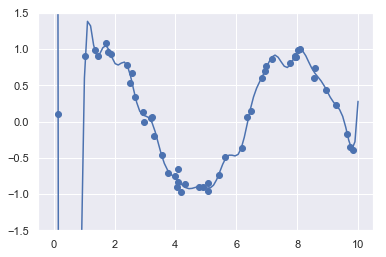

In [40]:
model = make_pipeline(GaussianFeatures(30),LinearRegression())
model.fit(x[:,np.newaxis],y)
plt.scatter(x,y)
plt.plot(X,model.predict(X))
plt.ylim(-1.5,1.5)

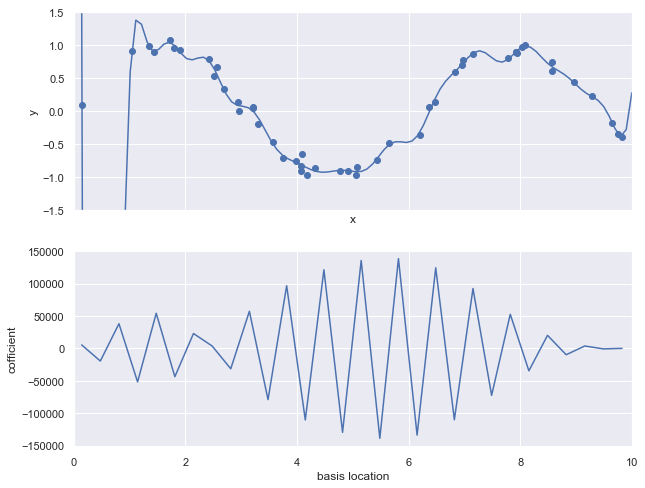

In [41]:
#可视化高斯基函数的系数
def basis_plot(model,title=None):
    fig,ax = plt.subplots(2,sharex=True,figsize=(10,8))
    model.fit(x[:,np.newaxis],y)
    ax[0].scatter(x,y)
    ax[0].plot(X,model.predict(X))
    ax[0].set(xlabel='x',ylabel='y',ylim=(-1.5,1.5))
    
    if title:
        ax[0].set_title(title)
    
    ax[1].plot(model.steps[0][1].centers_,model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',ylabel='cofficient',xlim=(0,10))

model = make_pipeline(GaussianFeatures(30),LinearRegression())
basis_plot(model)

> 上图显示了每个位置上基函数的振幅，当基函数重叠的时候，通常就表明出现了过拟合：相邻基函数的系数相互抵消。<br>
解决办法是对较大的模型参数进行惩罚，从而抑制模型剧烈波动，该惩罚机制被称为正则化(regularization)

#### 1.岭回归($L_2$范数正则化)
> 处理方法是对模型系数平方和($L_2$范数正则化)进行惩罚，模型拟合的惩罚项为：
<center>$P=\alpha \sum_{n=1}^N \theta_n^2$</center>

> 其中$\alpha$是一个自由参数，用来控制惩罚力度.
* 如果$\alpha \to 0$,那么模型就恢复到标准线性回归结果.
* 如果$\alpha \to \infty$,那么所有模型响应都会被压制.

> 岭回归的优点是计算非常高效



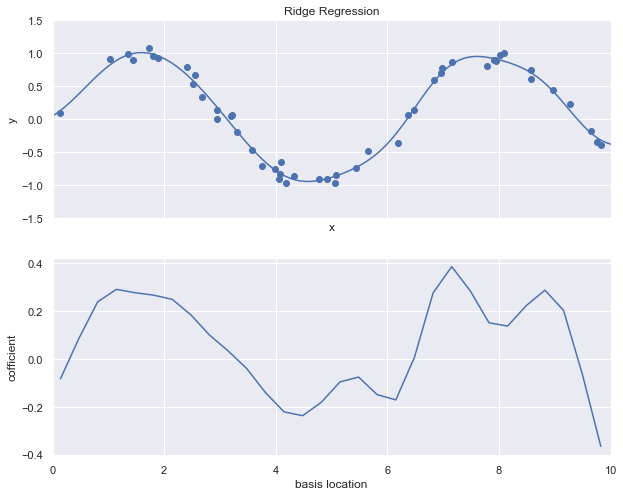

In [42]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30),Ridge(alpha=0.1))
basis_plot(model,title='Ridge Regression')

### 2. Lasso正则化($L_1$范数正则化)
> 处理方法是对模型系数绝对值的和($L_1$范数)进行惩罚，模型拟合的惩罚项为：
<center>$P=\alpha \sum_{n=1}^N|\theta_n|$</center>

> 其中$\alpha$是一个自由参数，用来控制惩罚力度.<br>
 Lasso正则化倾向于构造稀疏模型，即倾向于将模型系数设置为0

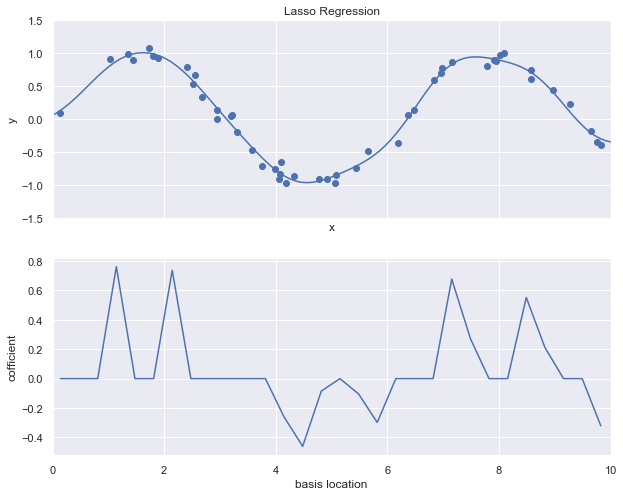

In [43]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30),Lasso(alpha=0.001))
basis_plot(model,title='Lasso Regression')